In [1]:
import itertools
import time
import torch
import torchvision
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from torchvision import models, transforms
from IPython.display import clear_output
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

In [2]:
SEED = 0xDEAD
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)

In [3]:
sns.set(style="darkgrid")

#### Data

In [4]:
batch_size = 128

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

num_gpus = torch.cuda.device_count()

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
)

# means = []
# stdevs = []

# for X, _ in trainloader:
#     means.append(X.mean(dim=(0, 2, 3)))
#     stdevs.append(X.std(dim=(0, 2, 3)))

# mean = torch.stack(means, dim=0).mean(dim=0)
# stdev = torch.stack(stdevs, dim=0).mean(dim=0)

# print(mean, stdev)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

num_classes = len(classes)
num_classes

Files already downloaded and verified
Files already downloaded and verified


10

#### Utils

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

nice

In [6]:
def plot_accuracy(
    model_name, phase, train_accuracy_history, test_accuracy_history
):
    epoch = len(train_accuracy_history) - 1

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"{model_name} on {phase}")

    plt.subplot(131)
    plt.plot(train_accuracy_history, "-x", label="train")
    plt.plot(test_accuracy_history, "-x", label="test")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Accuracy")

    current_train_accuracy = train_accuracy_history[-1]
    current_test_accuracy = test_accuracy_history[-1]

    plt.text(
        epoch,
        current_train_accuracy,
        f"{current_train_accuracy:.2f}%",
        va="center",
        ha="right",
    )
    plt.text(
        epoch,
        current_test_accuracy,
        f"{current_test_accuracy:.2f}%",
        va="center",
        ha="right",
    )

    plt.tight_layout()
    plt.show()

In [7]:
def plot_training_progress(
    model_name, phase, train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history
):
    clear_output(wait=True)

    epoch = len(train_loss_history) - 1

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"{model_name} on {phase}")
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, "-x", label="train")
    plt.plot(test_loss_history, "-x", label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title("Loss")

    current_train_loss = train_loss_history[-1]
    current_test_loss = test_loss_history[-1]

    plt.text(
        epoch, current_train_loss, f"{current_train_loss:.3f}", va="center", ha="right"
    )
    plt.text(
        epoch,
        current_test_loss,
        f"{current_test_loss:.3f}",
        va="center",
        ha="right",
    )

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_history, "-x", label="train")
    plt.plot(test_accuracy_history, "-x", label="test")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Accuracy")

    current_train_accuracy = train_accuracy_history[-1]
    current_test_accuracy = test_accuracy_history[-1]

    plt.text(
        epoch,
        current_train_accuracy,
        f"{current_train_accuracy:.2f}%",
        va="center",
        ha="right",
    )
    plt.text(
        epoch,
        current_test_accuracy,
        f"{current_test_accuracy:.2f}%",
        va="center",
        ha="right",
    )

    plt.tight_layout()
    plt.show()

In [8]:
def train_one_epoch(model, trainloader, criterion, optimizer, scheduler):
    
    train_loss = torch.tensor(0., device=device)
    train_accuracy = torch.tensor(0., device=device)

    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        
        with torch.no_grad():
            train_loss += loss * trainloader.batch_size
            train_accuracy += (torch.argmax(outputs, dim=1) == labels).sum()

    if scheduler:
        scheduler.step()

    return (train_loss/len(trainloader.dataset)).cpu(), (100*train_accuracy/len(trainloader.dataset)).cpu()

In [9]:
def evaluate(model, testloader, criterion):

    test_loss = torch.tensor(0., device=device)
    test_accuracy = torch.tensor(0., device=device)

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss * testloader.batch_size
            test_accuracy += (torch.argmax(outputs, dim=1) == labels).sum()

    return (test_loss/len(testloader.dataset)).cpu(), (100*test_accuracy/len(testloader.dataset)).cpu()

In [10]:
def train_and_evaluate(
    model,
    trainloader,
    testloader,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=10,
    model_name=None,
    phase="first",
):
    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []
    epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, train_accuracy = train_one_epoch(
            model, trainloader, criterion, optimizer, scheduler
        )
        end_time = time.time()
        model.eval()
        test_loss, test_accuracy = evaluate(model, testloader, criterion)


        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)
        epoch_times.append(end_time - start_time)

        plot_training_progress(
            model_name,
            phase,
            train_loss_history,
            test_loss_history,
            train_accuracy_history,
            test_accuracy_history,
        )

        print(
            "Epoch {}/{} (from 0-idx) Epoch Time: {:.2f} sec.\n"
            "Train Loss: {:5.3f}  Train Accuracy: {:5.2f}%\n"
            "Test Loss: {:6.3f}  Test Accuracy: {:6.2f}%".format(
                epoch,
                num_epochs - 1,
                epoch_times[-1],
                train_loss,
                train_accuracy,
                test_loss,
                test_accuracy,
            )
        )

    total_training_time = sum(epoch_times)
    avg_epoch_time = total_training_time / num_epochs

    print(
        f"Total train time: {total_training_time:.2f} sec.\n"
        f"Average epoch time: {avg_epoch_time:.2f} sec."
    )

    return (total_training_time, train_accuracy_history, test_accuracy_history)

### Pretrained models

In [11]:
def find_last_linear(model):
    last_linear_info = None
    for name, module in list(model.named_modules()):
        if isinstance(module, nn.Linear):
            parts = name.split(".")
            if len(parts) == 1:
                last_linear_info = (name, module)
            elif len(parts) == 2:
                last_linear_info = (parts[0], int(parts[1]), module)
    return last_linear_info

In [12]:
def freeze_except_last(model, last_layer):
    for name, param in model.named_parameters():
        param.requires_grad = name in [f"{last_layer}.weight", f"{last_layer}.bias"]

In [13]:
def freeze_except_block(model, last_layer, blocks):
    for name, param in model.named_parameters():
        in_block = any((block in name for block in blocks))
        param.requires_grad = (
            in_block or name == f"{last_layer}.weight" or name == f"{last_layer}.bias"
        )

The `xavier_uniform_` function initializes the weights to random values, following the _Xavier Initialization_ method with uniform distribution.

The _Xavier Initialization_ method sets the initial values of the weights so that their variance (the variance of the layer's inputs and outputs) is approximately the same.

In [14]:
def modify_layer_of_sequence(last_linear_info, model, num_classes):
    seq_name, seq_index, last_linear = last_linear_info
    seq = model._modules[seq_name]
    seq[seq_index] = nn.Linear(last_linear.in_features, num_classes).to(device)

    print(f"Modified Last Layer in Sequential: {seq[seq_index]}")

    # for param in seq[seq_index].parameters():
    #     param.requires_grad = True

    torch.nn.init.xavier_uniform_(seq[seq_index].weight)


def modify_model(model, phase="first", blocks=[]):
    last_linear_info = find_last_linear(model)
    print(f"Last layer: {last_linear_info}")

    if last_linear_info:
        if len(last_linear_info) == 2:
            last_linear_name, last_linear = last_linear_info
            model._modules[last_linear_name] = nn.Linear(
                last_linear.in_features, num_classes
            ).to(device)

            print(f"Modified Last Layer: {model._modules[last_linear_name]}")

            torch.nn.init.xavier_uniform_(model._modules[last_linear_name].weight)

        elif len(last_linear_info) == 3:
            modify_layer_of_sequence(last_linear_info, model, num_classes)

    if len(last_linear_info) == 2:
        last_layer_name = last_linear_info[0]
    if len(last_linear_info) == 3:
        name, index = last_linear_info[:2]
        last_layer_name = f"{name}.{str(index)}"

    if phase == "first":
        freeze_except_last(model, last_layer_name)
    if phase == "second":
        freeze_except_block(model, last_layer_name, blocks)
    return model

In [15]:
def count_all_params(model):
    num_params = sum(p.numel() for p in model.parameters())
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of parameters: {num_params}")
    print(f"Number of trainable parameters: {num_trainable_params}\n")
    return num_params, num_trainable_params

Since I am training models that are not all similar in architecture and for each I have experienced and exclusively selected training parameters — let’s create a training config for the models

In [16]:
config_params = {
    "resnet18": {
        "lr": 1e-2,
        "momentum": 0.85,
        "weight_decay": 5e-4,
        "step_size": 4,
        "gamma": 0.1,
        "num_epoch": 6,
        "blocks": ["conv1", "bn1", "layer1", "layer4"],
    },
    "resnet34": {
        "lr": 1e-2,
        "momentum": 0.85,
        "weight_decay": 5e-4,
        "step_size": 4,
        "gamma": 0.1,
        "num_epoch": 6,
        "blocks": ["conv1", "bn1", "layer1", "layer4"],
    },
    "mobilenet_v3_small": {
        "lr": 1e-1,
        "momentum": 0.9,
        "weight_decay": 5e-3,
        "T_max": 6,
        "eta_min": 1e-4,
        "num_epoch": 6,
        "blocks": [
            "features.0",
            "features.1",
            "features.11",
            "features.12",
            "classifier",
        ],
    },
    "shufflenet_v2_x1_5": {
        "lr": 1e-1,
        "momentum": 0.9,
        "weight_decay": 5e-3,
        "step_size": 4,
        "gamma": 0.1,
        "num_epoch": 6,
        "blocks": ["conv1", "conv5", "stage2", "stage4"],
    },
}

### Train and evaluate

In [17]:
warnings.filterwarnings(
    "ignore", category=UserWarning, module="torchvision.models._utils"
)

__Loss__ and __accuracy__ graphs are updated for each model and each experiment

In [18]:
results_frozen = {}
results_from_scratch = {}


def create_train_params(
    model_name, optimizer_params, scheduler_params, num_epoch, phase, blocks
):
    clear_output(wait=True)
    print(f"{model_name} on {phase} phase\n")

    try:
        model = getattr(models, model_name)(pretrained=True).to(device)
    except AttributeError:
        print(f"Model '{model_name}' not found in torchvision.models")

    modify_model(model, phase, blocks)
    trainable_params = count_all_params(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), **optimizer_params)

    if model_name in ["mobilenet_v3_small"]:
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, **scheduler_params)
    else:
        scheduler = lr_scheduler.StepLR(optimizer, **scheduler_params)

    results = train_and_evaluate(
        model,
        trainloader,
        testloader,
        criterion,
        optimizer,
        scheduler,
        num_epoch,
        model_name,
        phase,
    )

    if phase in ["first", "second"]:
        results_dict = results_frozen if phase == "first" else results_from_scratch
        results_dict[(model_name, phase)] = [
            results,
            optimizer,
            scheduler,
            blocks,
            trainable_params,
        ]

Import of parameters to the training cycle

In [19]:
def import_train_params(model_name, phase):
    params = config_params.get(model_name, {})
    optimizer_params = {
        "lr": params.get("lr", 1e-1),
        "momentum": params.get("momentum", 0.9),
        "weight_decay": params.get("weight_decay", 1e-4),
    }
    param_names = ["step_size", "gamma", "T_max", "eta_min"]
    scheduler_params = {
        param_name: params[param_name]
        for param_name in param_names
        if param_name in params
    }
    num_epoch = params.get("num_epoch", 30)
    blocks = params.get("blocks", [])

    create_train_params(
        model_name, 
        optimizer_params, 
        scheduler_params, 
        num_epoch, 
        phase, 
        blocks
    )

Models and types of transfer learning

- `resnet18` and `resnet34` are compared since I heard that they have good accuracy for `cifar10` in particular
as well as two smaller models so you don’t have to wait long (also in the comments below are more models that I trained, but did not contribute later)
- `batch_size` = 128 — optimal so that `cuda` does not crash due to memory overflow for these 4 models
- `num_epoch` = 6 for all models — I was already tired of waiting longer and at one point decided that I would rather qualitatively improve the models and select parameters within this number of epochs than wait more (after all, during these 5-6 epochs an `test_accuracy` of > 95 is achieved)
- two types of experiments are described below:

    *  _"first"_ — the __last layer__ is found in the model through the `find_last_linear` function (even if it is part of a sequence) and all layers except the last one found are frozen in the `modify_model` function through `freeze_except_last` (the last layer also changes `out_features` to `num_classes` in the `modify_model` function by redefining the last layer with a new `out_features` value — the weights in it are initialized via `xavier_uniform_`)
    * _"second"_ — everything is the same as in _"first"_, but also from the `config_params` _"blocks"_ of each model a list is taken with layers that will be additionally trained (the head — the __last layers__ of the model, not only the very last, and the end of the tail — the __first conv and first bn layers__ or the first two and last two blocks of models)

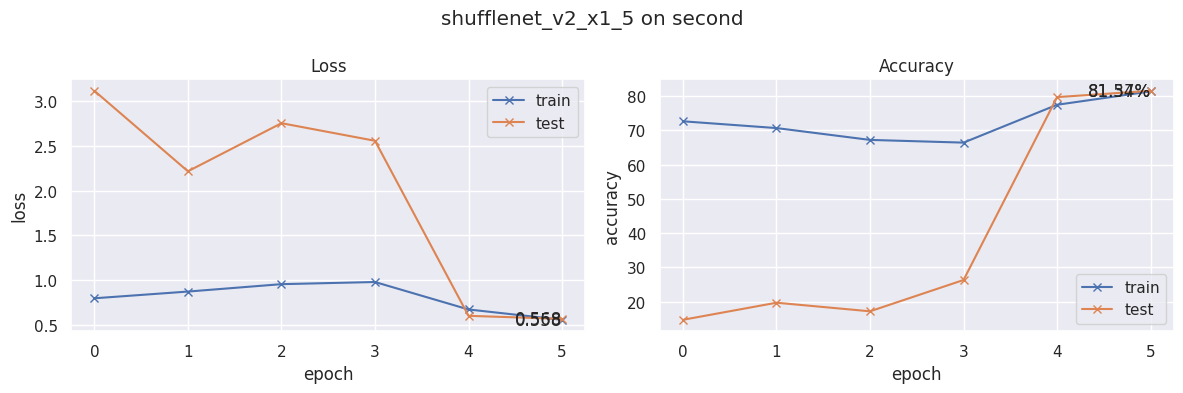

Epoch 5/5 (from 0-idx) Epoch Time: 51.31 sec.
Train Loss: 0.558  Train Accuracy: 81.37%
Test Loss:  0.568  Test Accuracy:  81.54%
Total train time: 308.03 sec.
Average epoch time: 51.34 sec.


In [20]:
# "resnet18", "resnet34", "resnet50", "resnext50_32x4d", "mobilenet_v2", "shufflenet_v2_x2_0"
model_names = [
    "resnet18",
    "resnet34",
    "mobilenet_v3_small",
    "shufflenet_v2_x1_5",
]
types_of_exps = ["first", "second"]

for model_name, phase in itertools.product(model_names, types_of_exps):
    import_train_params(model_name, phase)

In [21]:
warnings.filterwarnings(
    "default", category=UserWarning, module="torchvision.models._utils"
)

Saving results

In [22]:
results_frozen_df = pd.DataFrame(results_frozen)
results_frozen_df.to_csv("pw2_frozen.csv", index=False)

results_from_scratch_df = pd.DataFrame(results_from_scratch)
results_from_scratch_df.to_csv("pw2_scratch.csv", index=False)

In [23]:
test_accuracy_first = {}
test_accuracy_sec = {}

for key, value in results_frozen_df.items():
    model_name, _ = key
    test_accuracy_first[model_name] = value[0][2][-1]  # from create_train_params results_dict
first_df = pd.DataFrame(
    test_accuracy_first.items(), columns=["model_name", "first"]
).set_index("model_name")

for key, value in results_from_scratch_df.items():
    model_name, _ = key
    test_accuracy_sec[model_name] = value[0][2][-1]
sec_df = pd.DataFrame(
    test_accuracy_sec.items(), columns=["model_name", "second"]
).set_index("model_name")

print(first_df)

print(sec_df)

                              first
model_name                         
resnet18            tensor(79.4300)
resnet34            tensor(80.3600)
mobilenet_v3_small  tensor(83.7500)
shufflenet_v2_x1_5  tensor(82.1900)
                             second
model_name                         
resnet18            tensor(95.7100)
resnet34            tensor(96.7100)
mobilenet_v3_small  tensor(79.9600)
shufflenet_v2_x1_5  tensor(81.5400)


In [24]:
def process_value(value):
    return round(float(value.item()), 2)


result_df = pd.concat([first_df["first"], sec_df["second"]], axis=1)
result_df = result_df.map(process_value)
print(result_df)

                    first  second
model_name                       
resnet18            79.43   95.71
resnet34            80.36   96.71
mobilenet_v3_small  83.75   79.96
shufflenet_v2_x1_5  82.19   81.54


### Results

In [25]:
max_element = result_df.values.max()
row_idx, col_idx = (result_df.values == max_element).nonzero()

row_name = result_df.index[row_idx[0]]
col_name = result_df.columns[col_idx[0]]

result = results_from_scratch.get((row_name, col_name), None)
print(
    f"model {row_name} in {col_name} experiment with {max_element}% test_accuracy\n",
    f"time of training {round(result[0][0], 2)} sec.\n",
    f"optimizer {result[1]}\n",
    f"scheduler.step_size {result[2].step_size}\n",
    f"scheduler.gamma {result[2].gamma}\n",
    f"trainable blocks {result[3]}\n",
    f"total num params {result[4][0]}\n",
    f"trainable params {result[4][1]}\n",
)

model resnet34 in second experiment with 96.71% test_accuracy
 time of training 490.52 sec.
 optimizer SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.01
    lr: 0.001
    maximize: False
    momentum: 0.85
    nesterov: False
    weight_decay: 0.0005
)
 scheduler.step_size 4
 scheduler.gamma 0.1
 trainable blocks ['conv1', 'bn1', 'layer1', 'layer4']
 total num params 21289802
 trainable params 17115210



Let's add `test_accuracy` results from 1 practical work — "similar_to_AlexNet"

In [26]:
pw1_results = pd.read_csv("pw1_results.csv")
pw1_results = pw1_results.iloc[1:]
pw1_results = pw1_results.rename(index={pw1_results.index[-1]: "similar_to_AlexNet"})
all_results = pd.concat([result_df, pw1_results], axis=0)
all_results

,first,second,0
resnet18,79.43,95.71,NaN
resnet34,80.36,96.71,NaN
mobilenet_v3_small,83.75,79.96,NaN
shufflenet_v2_x1_5,82.19,81.54,NaN
similar_to_AlexNet,NaN,NaN,89.68


In [27]:
pw1_results = pw1_results.rename(index={pw1_results.index[-1]: "similar_to_AlexNet"})
melted_result_df = result_df.melt(var_name="experiment", value_name="accuracy", ignore_index=False)
melted_pw1_results = pw1_results.melt(var_name="experiment", value_name="accuracy", ignore_index=False)
all_results = pd.concat([melted_result_df, melted_pw1_results])
all_results.reset_index(inplace=True, names="model")
all_results

,model,experiment,accuracy
0,resnet18,first,79.43
1,resnet34,first,80.36
2,mobilenet_v3_small,first,83.75
3,shufflenet_v2_x1_5,first,82.19
4,resnet18,second,95.71
5,resnet34,second,96.71
6,mobilenet_v3_small,second,79.96
7,shufflenet_v2_x1_5,second,81.54
8,similar_to_AlexNet,0,89.68


Comparative histogram of classification accuracy results

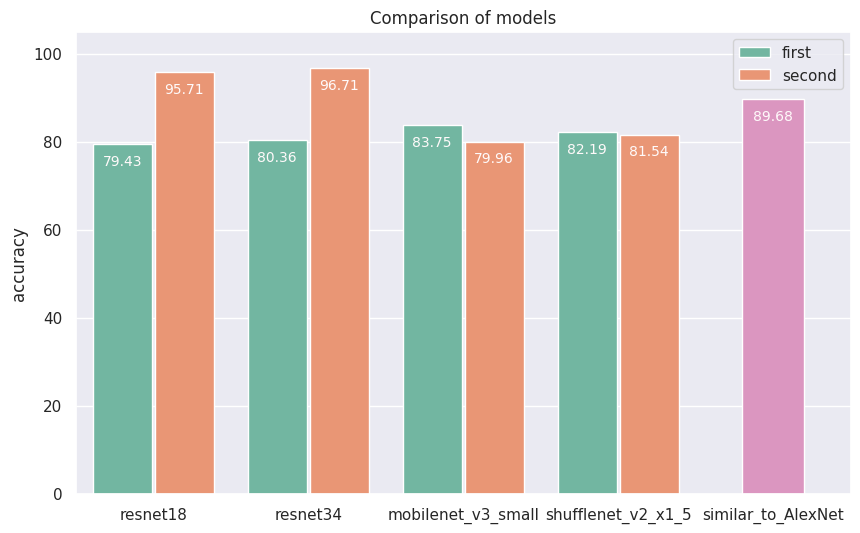

In [28]:
similar_to_AlexNet_data = all_results[all_results["model"] == "similar_to_AlexNet"]
filtered_results = all_results[all_results["model"] != "similar_to_AlexNet"]

plt.figure(figsize=(10, 6))

sns.barplot(
    data=filtered_results,
    x="model",
    y="accuracy",
    hue="experiment",
    palette=sns.color_palette("Set2")[:2],
    gap=0.05,
)
sns.barplot(
    data=similar_to_AlexNet_data,
    x="model",
    y="accuracy",
    color=sns.color_palette("Set2")[3],
    width=0.4,
)

plt.title("Comparison of models")
plt.ylim(0, 105)
plt.xlabel("")
ax = plt.gca()
plt.legend()

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height() - 7),
        ha="center",
        va="center",
        fontsize=10,
        color="snow",
        xytext=(0, 10),
        textcoords="offset points",
    )
plt.show()